# Convolutional Neural Networks

## Dog breed classification using transfer learning



## Step 1: import dataset

Make sure that you've downloaded the required dog dataset:
* Download the dataset, unzip the folder and place it in this project's home directory, at the location `/dogs`. 

In [1]:
import numpy as np
from glob import glob

# load filenames
dog_files = np.array(glob("dogs/*/*/*"))

# print the number of images in the dataset
print('There are %d total dog images.' % len(dog_files))

There are 8351 total dog images.


## Step 2: detect dogs

In this section, we will use a Pre-trained VGG16 Model to detect dogs.

The following code cell downloads the VGG16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a large, popular dataset used for image classification with 1000 categories.

In [2]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available and move model to GPU
use_cuda = torch.cuda.is_available()
if use_cuda:
    VGG16 = VGG16.cuda()

c:\Users\m_a_g\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\m_a_g\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Using the pre-trained model

Next, we will write a function that accepts as input a path to an image, and returns an integer between 0 and 999 (inclusive), representing one of the 1000 possible classes.
Note that VGG16 requires an imput image size of 224x224.

In [3]:
from PIL import Image
import torchvision.transforms as transforms

# Set PIL to be tolerant of image files that are truncated.
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG16 model to obtain index corresponding to 
    predicted class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG16 model's prediction
    '''

    image = Image.open(img_path).convert('RGB')
    normalize = transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.25, 0.25, 0.25])])
    
    image = normalize(image)[:3,:,:].unsqueeze(0)
    
    if use_cuda:
        image = image.cuda()
        
    classify=VGG16(image)
    
    index = classify.argmax().item() #index of the class with highest proba returned as scalar
    
    return index # predicted class index

Among output classes, categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268 (inclusive).  Therefore, to verify whether a dog is detected, we only need to check if the pre-trained model predicts an index between 151 and 268.

The `dog_detector` function below returns `True` if a dog is detected in an image, and `False` if not.

In [4]:
def dog_detector(img_path):
    res_ = VGG16_predict(img_path)
    if  (res_ >= 151 and res_ <= 268):
        return True
    else:
        return False

### Test your dog detector

In [5]:
# Test the performance of the dog_detector function
# on the first 100 images.

dog_files_short = dog_files[:100]
count_dog_dog=0
for img in dog_files_short:
    if dog_detector(img):
        count_dog_dog+=1
        
print ('Dogs detected: ' , count_dog_dog , '%')

Dogs detected:  95 %


## Step 3: create a CNN to classify dog breeds using transfer learning
### Specify data loaders 

In the following code cell, we write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets (located at `dogs/train`, `dogs/valid`, and `dogs/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [6]:
import os
from torchvision import datasets

# Writing data loaders for training, validation, and test sets
# Specifying appropriate transforms, and batch_sizes
batch_size  = 20
num_workers = 0

img_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.25, 0.25, 0.25))  
    ])

train_data=datasets.ImageFolder('dogs/train', transform = img_transform)
validation_data=datasets.ImageFolder('dogs/valid', transform = img_transform)
test_data=datasets.ImageFolder('dogs/test', transform = img_transform)         

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

loaders_transfer = {
    'train': train_loader,
    'valid': valid_loader,
    'test': test_loader
}


### Model architecture

Transfer learning is used to create a CNN to classify dog breed.  The initialized model will be saved as the variable `model_transfer`.


In [7]:
import torchvision.models as models
import torch.nn as nn

# model architecture 
model_transfer = models.vgg16(pretrained=True)
print(model_transfer)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

When we print the model, we can see the model's architecture. The last fully-connected layer is at index 6 in the Classifier part of our CNN. Now will change change the number of ouputs from 1000 to 133, thus customizing the classification of VGG16 to our dataset of 133 possible dog breeds. We will also freeze the feature extraction part of our CNN.

In [8]:
model_transfer.classifier[6]=nn.Linear(model_transfer.classifier[6].in_features, 133)
for param in model_transfer.features.parameters():
    param.requires_grad = False #freeze CNN params from retraining

if use_cuda:
    model_transfer = model_transfer.cuda()

### Specify loss function and optimizer

The following code cell is used to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and an [optimizer](http://pytorch.org/docs/master/optim.html).  The chosen loss function is saved as `criterion_transfer`, and the optimizer as `optimizer_transfer`.

In [9]:
import torch.optim as optim
criterion_transfer = torch.nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.classifier.parameters(), lr=0.01)

### Train and validate the model

Now we will train and validate our model, and we will save the model parameters as save_path `'model_transfer.pt'`.

In [10]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            # find the loss and update the model parameters accordingly
            # record the average training loss
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)     
            loss.backward()   
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.item() - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.item() - valid_loss))
            
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        # save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss    
    # return trained model
            
    return model


# train the model
n_epochs = 100
model_transfer = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 2.411013 	Validation Loss: 1.438834
Validation loss decreased (inf --> 1.438834).  Saving model ...
Epoch: 2 	Training Loss: 1.477033 	Validation Loss: 1.232676
Validation loss decreased (1.438834 --> 1.232676).  Saving model ...
Epoch: 3 	Training Loss: 1.369109 	Validation Loss: 1.186824
Validation loss decreased (1.232676 --> 1.186824).  Saving model ...
Epoch: 4 	Training Loss: 1.232401 	Validation Loss: 1.232954
Epoch: 5 	Training Loss: 1.175460 	Validation Loss: 1.138683
Validation loss decreased (1.186824 --> 1.138683).  Saving model ...
Epoch: 6 	Training Loss: 1.136288 	Validation Loss: 1.055140
Validation loss decreased (1.138683 --> 1.055140).  Saving model ...
Epoch: 7 	Training Loss: 1.102340 	Validation Loss: 1.045184
Validation loss decreased (1.055140 --> 1.045184).  Saving model ...
Epoch: 8 	Training Loss: 1.076601 	Validation Loss: 1.035057
Validation loss decreased (1.045184 --> 1.035057).  Saving model ...
Epoch: 9 	Training Loss: 1.049971 

<All keys matched successfully>

### Test the model

Let's try out our model on the test dataset. We will calculate and print the test loss and accuracy.  

In [11]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))
    
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 1.023591


Test Accuracy: 72% (605/836)


### Predict dog breed with the model

Let's write a function that takes an image path as input and returns the dog breed that is predicted by our model.  

In [14]:
# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in loaders_transfer['train'].dataset.classes]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    image = Image.open(img_path).convert('RGB')
    normalize = transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.25, 0.25, 0.25])])

    image = normalize(image)[:3,:,:].unsqueeze(0)
    
    if use_cuda:
        image = image.cuda()
        
    classify=model_transfer(image)   
    index = classify.argmax().item() #index of the class with highest proba returned as scalar
    
    
    return class_names[index]

Now let us try with our own images. Create a folder named myImages and put inside some dog images that you obtain
from the internet (or from your smartphone camera if you own one or more dogs...)

In [27]:
pip install opencv-python

   ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.6 MB 1.4 MB/s eta 0:00:29
   ---------------------------------------- 0.1/38.6 MB 660.6 kB/s eta 0:00:59
   ---------------------------------------- 0.1/38.6 MB 950.9 kB/s eta 0:00:41
   ---------------------------------------- 0.2/38.6 MB 1.1 MB/s eta 0:00:34
   ---------------------------------------- 0.2/38.6 MB 1.0 MB/s eta 0:00:38
   ---------------------------------------- 0.3/38.6 MB 1.1 MB/s eta 0:00:37
   ---------------------------------------- 0.3/38.6 MB 951.8 kB/s eta 0:00:41
   ---------------------------------------- 0.4/38.6 MB 955.7 kB/s eta 0:00:41
   ---------------------------------------- 0.4/38.6 MB 1.0 MB/s eta 0:00:37
    --------------------------------------- 0.5/38.6 MB 1.0 MB/s eta 0:00:38
    --------------------------------------- 0.6/38.6 MB 1.1 MB/s eta 0:00:35
    --------------------------------------- 0.6/38.6 MB 1.1 MB/s eta 0:00:3

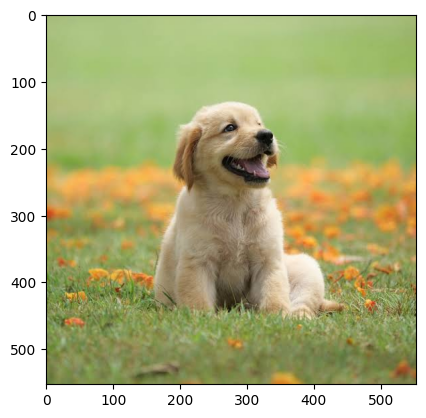

This dog breed is likely a  Golden retriever


In [28]:
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image

imgsFolder='myImages/' 
for imgFile in os.listdir(imgsFolder):
    img_path=os.path.join(imgsFolder,imgFile)
    img = cv2.imread(img_path)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()
    print("This dog breed is likely a ", predict_breed_transfer(img_path))
                
    